In [24]:
import yaml
from scipy.ndimage import map_coordinates
import pickle
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column
import matplotlib as mpl
from astropy import constants, units
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 20
path = '/Users/arcticfox/Documents/disks/models'
parula = np.load('/Users/arcticfox/parula_colors.npy')

In [2]:
def open_raw(path):
    try:
        with open(os.path.join(path,'distdata_raw.pkl'), 'rb') as infile:
                  diskinp = pickle.load(infile)
                  ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze = diskinp
    except:
        with open(os.path.join(path,'diskdata_raw.pkl'), 'rb') as infile:
                  diskinp = pickle.load(infile)
                  ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze = diskinp
    return ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze

def open_interp(path):
    with open(os.path.join(path,'diskdata_interpolated.pkl'), 'rb') as infile:
                  diskinp = pickle.load(infile)
                  ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze = diskinp
    return ddustsm, ddustlg, tdustsm, tdustlg, dgas, tgas, re, ze

def pressure_profile(rho, T, mu=2.3):
    rho = rho * units.g / units.cm**3
    T = T * units.K
    
    kB = 1.3806*10**-23 * units.Joule / units.K
    mH = 1.67*10**-24 * units.g
    
    cs = (kB * T) / (mu * mH)
    P = rho * cs
    return P.to(units.Joule/units.cm**3)

def scale_height(r, midplane, mstar, mu=2.3):
    Tm = np.nanmedian(midplane)*units.K
    r = r * units.AU
    mstar = mstar * units.Msun
    
    kB = 1.3806*10**-23 * units.Joule / units.K
    mH = 1.67*10**-24 * units.g
    
    num = kB * Tm * r**3
    denom = constants.G * mstar * mu * mH
    return np.sqrt(num/denom).to(units.AU)

In [3]:
def plot_contour(data, cmap, ticks, ax, label, index=5, contourcolor=['k'], 
                 skipticks=0, logNorm=False, xlim=None, ylim=None, 
                 pressure=False, mu=2.3, add_cbar=True, add_xlabel=True):
    
    cmap = mpl.cm.get_cmap(cmap)
    cmap.set_under('w')
    cmap.set_over(cmap(1.0))
    
    if pressure == False:
        dat = data[index] + 0.0
    else:
        dat = pressure_profile(data[4], data[5], mu=mu).value
    
    if logNorm == False:
        im = ax.pcolormesh(data[-2], data[-1], dat, cmap=cmap,
                           vmin=np.nanmin(ticks), vmax=np.nanmax(ticks))#,
                       #norm=mpl.colors.LogNorm(vmin=np.nanmin(ticks), vmax=np.nanmax(ticks)))
    else:
        im = ax.pcolormesh(data[-2], data[-1], dat, cmap=cmap,
                           norm=mpl.colors.LogNorm(vmin=np.nanmin(ticks), 
                                                   vmax=np.nanmax(ticks)))
        
    ax.contour(data[-2], data[-1], dat, ticks, colors=contourcolor)
    div = make_axes_locatable(ax)
    if add_cbar:
        cax = div.append_axes('top', size='6%', pad=0.1)
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=ticks[skipticks:])
        cbar.set_label(label, fontsize=16)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')
        cbar.ax.tick_params(labelsize = 14)
    if add_xlabel:
        ax.set_xlabel('R [AU]')
    
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    
    ax.set_rasterized(True)
    
    return

In [4]:
def make_subplots(data_paths, labels, transparent=False):
    fig, axes = plt.subplots(ncols=4, nrows=len(data_paths), 
                             figsize=(8*len(data_paths), 6*len(data_paths)), sharex=True)
    
    if transparent==False:
        fig.set_facecolor('w')
    
    i = 0
    x = 0
    data = [open_interp(j) for j in data_paths]
    
    add_cbar, add_xlabel = True, False
    for ax in axes.reshape(-1):
        
        if i>3:
            add_cbar=False
        if i > 3+4*np.arange(0,len(data_paths),1)[-2]:
            add_xlabel=True
        
        if i in 0+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'RdYlBu_r', ticks=tdust_ticks, 
                         ax=ax, label='T$_{dust, lg}$ [K]',
                         index=3,ylim=ylim,add_cbar=add_cbar,
                         add_xlabel=add_xlabel)
            ax.set_ylabel('{}'.format(labels[x]),fontsize=26)
        if i in 1+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'RdYlBu_r', ticks=tgas_ticks, 
                         ax=ax, label='T$_{gas}$ [K]', 
                         skipticks=4,ylim=ylim,add_cbar=add_cbar,
                         add_xlabel=add_xlabel)
        if i in 2+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'viridis', ticks=p_ticks, 
                         ax=ax, label=r'$P_{gas}$ [J cm$^{-3}$]',
                         logNorm=True,ylim=ylim,pressure=True,
                         add_cbar=add_cbar, add_xlabel=add_xlabel)
        if i in 3+4*np.arange(0,len(data_paths),1):
            plot_contour(data[x], 'plasma', ticks=dgas_ticks, 
                         ax=ax, label=r'$\rho_{gas}$ [cm$^{-3}$]',
                         index=4, logNorm=True,ylim=ylim,
                         add_cbar=add_cbar, add_xlabel=add_xlabel)

        if i >= 3+4*np.arange(0,len(data_paths),1)[x]:
            x += 1
        i += 1
        
        ax.set_rasterized(True)

    return fig

In [5]:
data_folders = ['bigdisk', 'bigdisk100_newhh', 'bigdisk100_lum', 
                'lstar_test', 'bigdisk100', 'baseline']
labels = ['Quiescent', 'UV, new h', 'L+UV, new h', 'L+UV, old h', 'UV, old h',
         'TW Hydra']
data_paths = [os.path.join(path, i) for i in data_folders]

In [6]:
tdust_ticks = np.linspace(50,1500,9)
tgas_ticks = np.logspace(1,3.3, 10)
dgas_ticks = np.logspace(5,14,9)
p_ticks = 10**np.linspace(8,20,9)
ylim=[0,3]

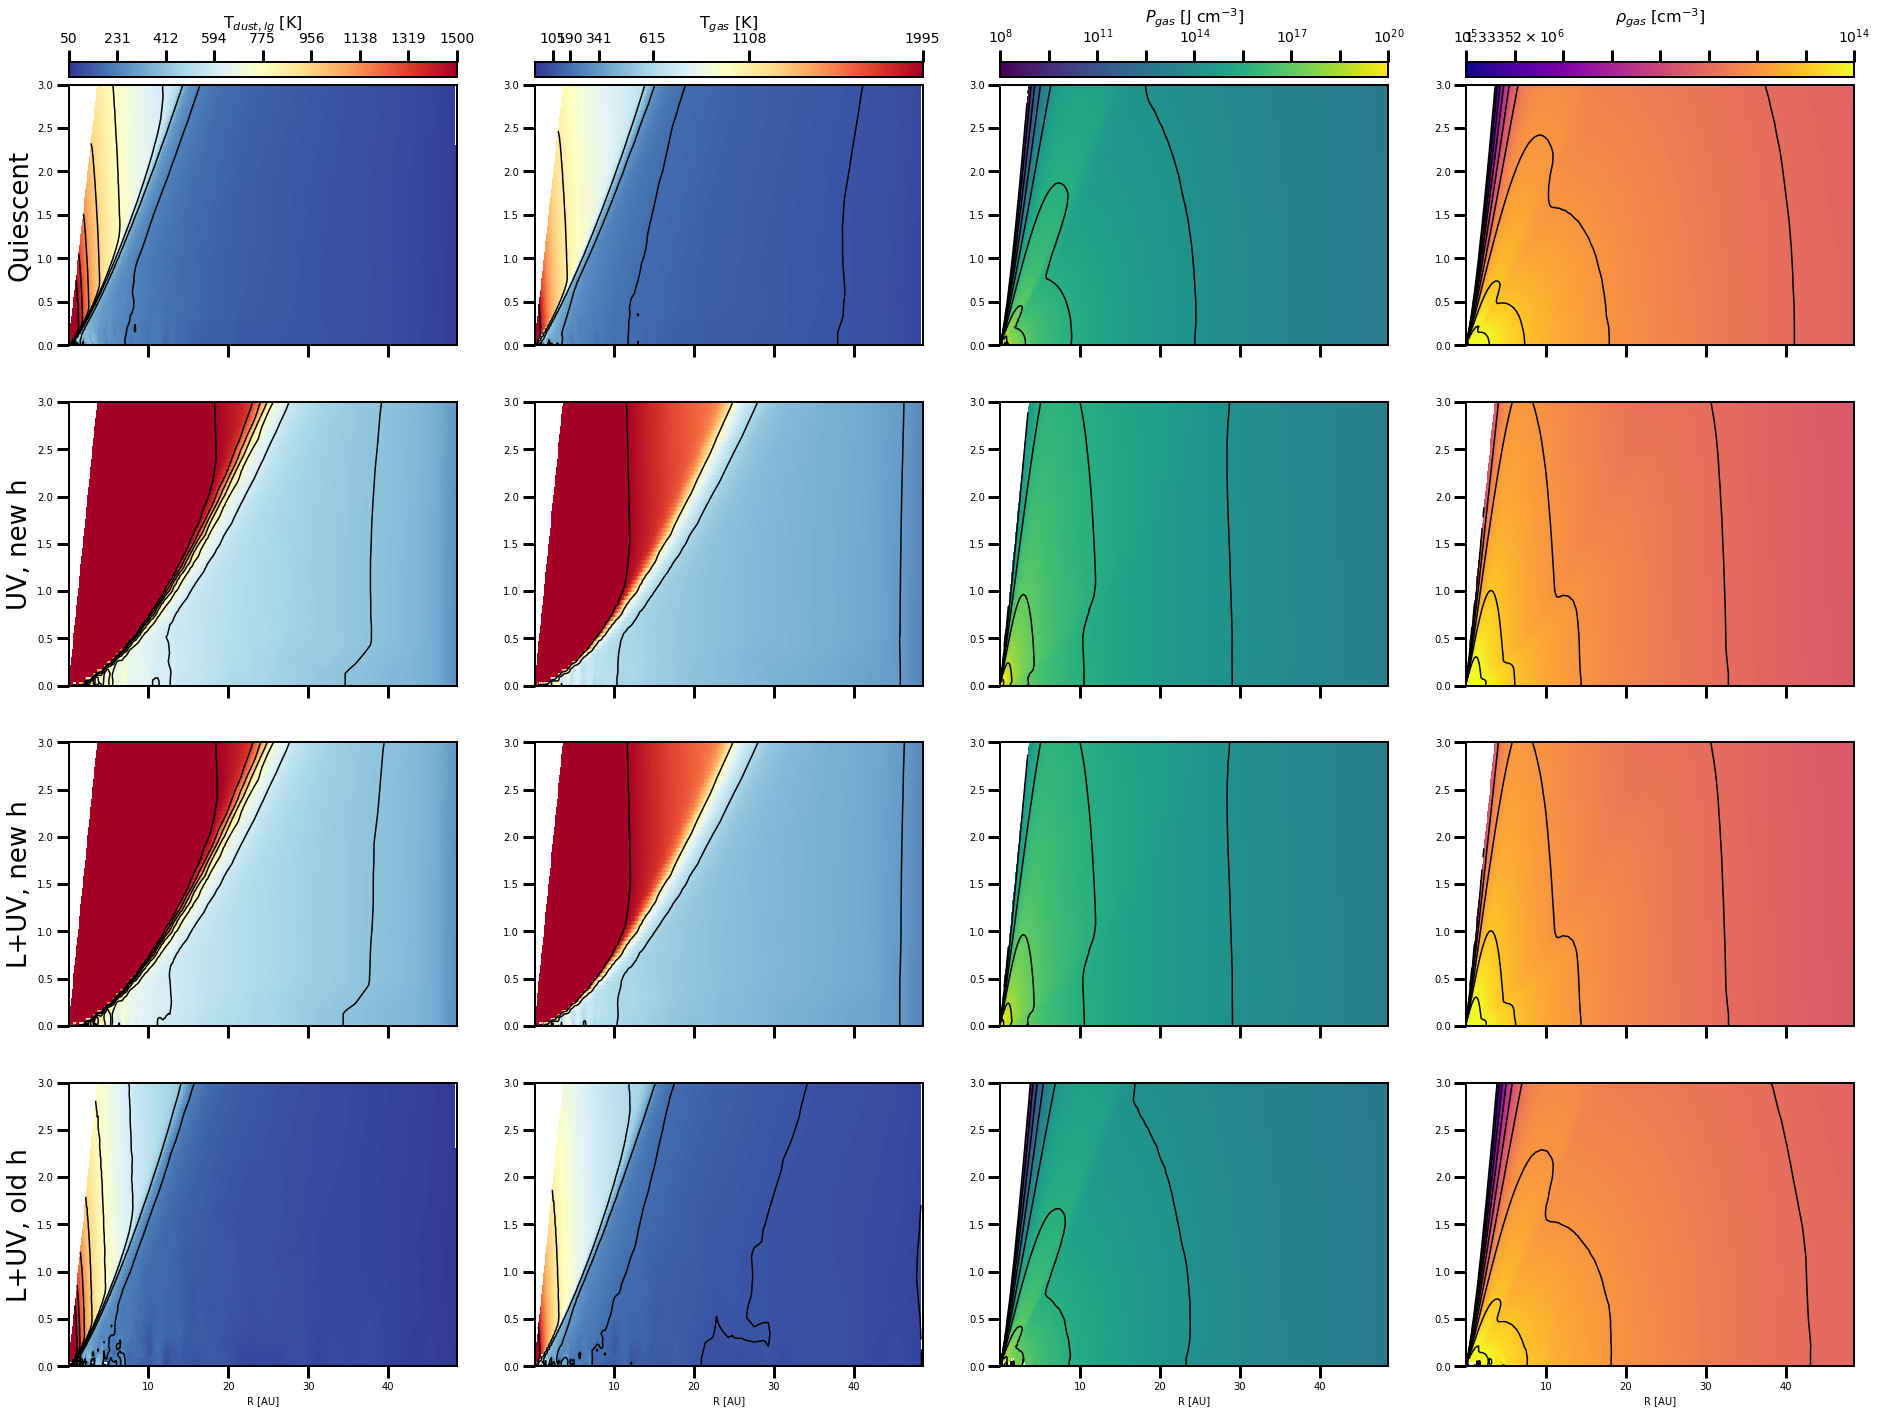

In [22]:
fig = make_subplots(data_paths, labels)
#fig.savefig('/Users/arcticfox/Documents/GitHub/disks_and_outbursts/figures/compare_with_oldh_midplane.png',
#            rasterize=True, bbox_inches='tight', dpi=250)

In [13]:
data = [open_raw(j) for j in data_paths]

In [33]:
def make_line_profiles(data, index, zrs=[0,0.1,0.2,0.3,0.4], p=None):
    global ntheta, nr
    
    r2d = data[-2].reshape(ntheta,nr)
    z2d = data[-1].reshape(ntheta,nr)
    if p is None:
        var2d = data[index].reshape(ntheta,nr)
    else:
        var2d = p.reshape(ntheta,nr)

    zvals = []
    rvals = []
    var_slices = []
    for nn in zrs:
        vv = np.argmin(np.abs(z2d/r2d-nn),axis=0)[0]
        var_slices.append(var2d[vv])
        rvals.append(r2d[vv])
        zvals.append(z2d[vv])
        print(nn)
        
    return rvals, zvals, var_slices

In [34]:
output_labels = [r'$\rho_{dust, small}$ [cm$^{-3}$]',
                 r'$\rho_{dust, large}$ [cm$^{-3}$]',
                 'T$_{dust, small}$ [K]',
                 'T$_{dust, large}$ [K]',
                 r'$\rho_{gas}$ [cm$^{-3}$]',
                 'T$_{gas}$ [K]',
                 'P$_{gas}$ [J cm$^{-3}$]']

output_label_raw = [r'$\rho_{dust, small}$ [cm$^{-3}$]',
                 r'$\rho_{dust, large}$ [cm$^{-3}$]',
                 'T$_{dust, small}$ [K]',
                 'T$_{dust, large}$ [K]',
              'T$_{gas}$ [K]',
                 r'$\rho_{gas}$ [cm$^{-3}$]',
                 
                 'P$_{gas}$ [J cm$^{-3}$]']

output_interp = ['rhodustsm', 'rhodustlg', 'tdustsm', 'tdustlg', 'rhogas', 'tgas', 'pressure']
output_raw = ['rhodustsm', 'rhodustlg', 'tdustsm', 'tdustlg', 'tgas', 'rhogas', 'pressure']

tick_list = [0, 0, tdust_ticks, tdust_ticks, dgas_ticks, tgas_ticks, p_ticks]

### interp =  ['rhodustsm', 'rhodustlg', 'tdustsm', 'tdustlg', 'rhogas', 'tgas', 'pressure']
### raw = [ddustsm, ddustlg, tdustsm, tdustlg, tgas, dgas, rr, zz]

In [35]:
print(data_folders)
ntheta = 90 
nr = 110

['bigdisk', 'bigdisk100_newhh', 'bigdisk100_lum', 'lstar_test', 'bigdisk100', 'baseline']


0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4


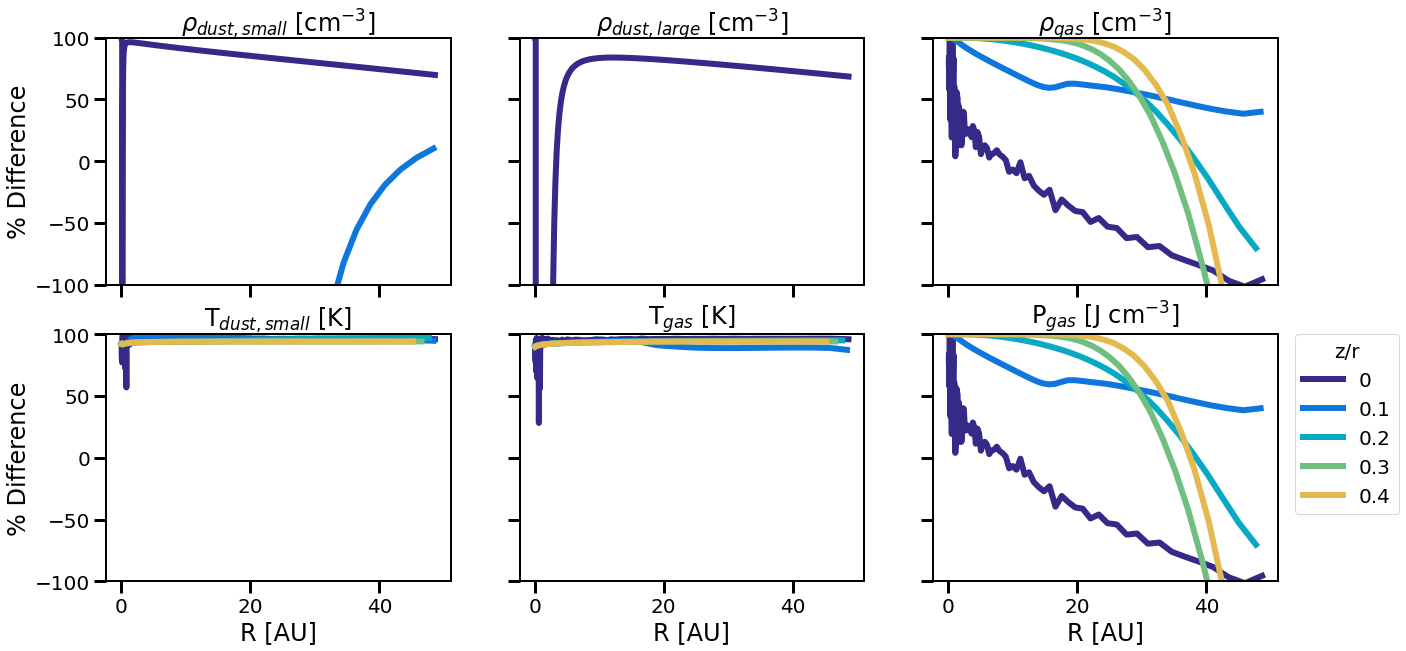

In [36]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(21,10), sharex=True, sharey=True)
ax = axes.reshape(-1)
fig.set_facecolor('w')

indices = [0, 1, 5, 2, 4, 6]
zrs = [0,0.1,0.2,0.3,0.4]

d_new = open_raw(data_paths[1])
d_old = open_raw(data_paths[-1])

for i in range(len(ax)):
    
    if indices[i] != 6:
        rrn, zzn, ddn = make_line_profiles(d_new, indices[i], zrs=zrs)
        rro, zzo, ddo = make_line_profiles(d_old, indices[i], zrs=zrs)
    else:
        pn = pressure_profile(d_new[5], d_new[4], mu=2.3).value
        rrn, zzn, ddn = make_line_profiles(d_new, indices[i], p=pn, zrs=zrs)
        
        po = pressure_profile(d_old[5], d_new[4], mu=2.3).value
        rro, zzo, ddo = make_line_profiles(d_old, indices[i], p=po, zrs=zrs)
    
    ax[i].set_title(output_label_raw[indices[i]])
    
    for j in range(len(rrn)):
        diff = (ddn[j]-ddo[j])/ddn[j]*100
        mask = (np.isnan(diff)==False) & (np.isfinite(diff)==True)
        if  i < 5:
            ax[i].plot(rrn[j][mask], diff[mask], c=parula[j*50], lw=6)
        else:
            ax[i].plot(rrn[j][mask], diff[mask], c=parula[j*50], lw=6,
                       label=zrs[j])
        
    if i == 5:
        leg = ax[i].legend(bbox_to_anchor=(1.05, 1), 
                           loc='upper left', borderaxespad=0.)
        leg.set_title('z/r')
    if i >= 3:
        ax[i].set_xlabel('R [AU]', fontsize=24)
    if i == 0 or i ==3:
        ax[i].set_ylabel('% Difference', fontsize=24)
    
    if i > 1:
        ax[i].set_ylim(-100,100)


    ax[i].set_rasterized(True)
#plt.savefig('/Users/arcticfox/Documents/disks/figures/comparison_new_vs_old_h.png',
#            rasterize=True, bbox_inches='tight', dpi=250)

scale height goes as (r/150)^hh power, where hh is the scale height gradient

In [46]:
d_q = open_raw(data_paths[0])
d_o = open_raw(data_paths[1])
d_qi = open_interp(data_paths[1])
rr, zz, tm_q = make_line_profiles(d_q, index=4, zrs=zrs)
rr, zz, tm_o = make_line_profiles(d_o, index=4, zrs=zrs)

0
0.1
0.2
0.3
0.4
0
0.1
0.2
0.3
0.4


In [47]:
zrs

[0, 0.1, 0.2, 0.3, 0.4]

Text(0.5, 1.0, 'Herbig Disk Model')

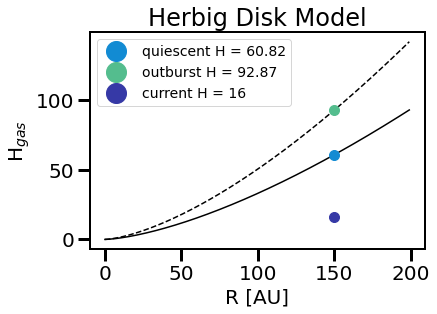

In [48]:
rr = np.arange(0,200,1)

newh = scale_height(150, tm_q[0], 1.3).value
hout = scale_height(150, tm_o[0], 1.3).value
fig = plt.figure()
fig.set_facecolor('w')

plt.plot(rr, scale_height(rr, tm_q[0], 1.3).value, 'k')
plt.plot(rr, scale_height(rr, tm_o[0], 1.3).value, 'k--')

plt.plot(150, scale_height(150, tm_q[0], 1.3).value, 'o', 
         c=parula[70], ms=10, label='quiescent H = {}'.format(np.round(newh,2)))
plt.plot(150, scale_height(150, tm_o[0], 1.3).value, 'o', 
         c=parula[140], ms=10, label='outburst H = {}'.format(np.round(hout,2)))
plt.plot(150, 16, 'o', ms=10, label='current H = 16', c=parula[10])
plt.legend(fontsize=14)
plt.xlabel('R [AU]')
plt.ylabel('H$_{gas}$')
plt.title('Herbig Disk Model')
#plt.savefig('/Users/arcticfox/Documents/disks/figures/scale_height_comp_herbig.png',
#             rasterize=True, dpi=250, bbox_inches='tight')

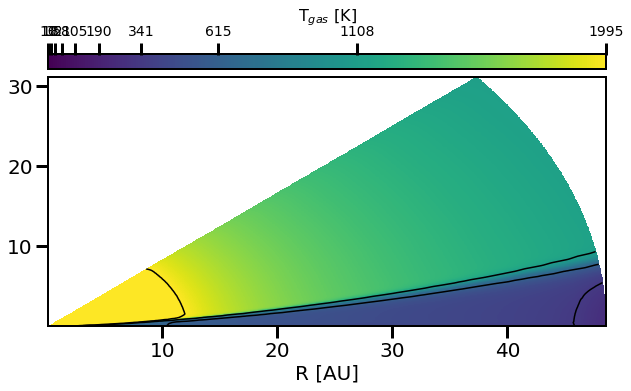

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
plot_contour(d_qi, 'viridis', tgas_ticks, ax, 'T$_{gas}$ [K]', index=5)

In [21]:
d_tw = open_raw(data_paths[-1])
rr, zz, tm_q = make_line_profiles(d_tw, index=2, zrs=zrs)

Text(0.5, 1.0, 'TW Hydrae Model')

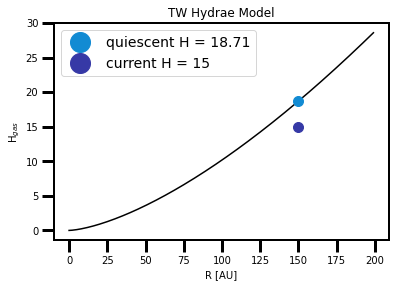

In [22]:
rr = np.arange(0,200,1)

newh = scale_height(150, tm_q[0], 1.3).value
hout = scale_height(150, tm_o[0], 1.3).value

fig = plt.figure()
fig.set_facecolor('w')

plt.plot(rr, scale_height(rr, tm_q[0], 1.3).value, 'k')
#plt.plot(rr, scale_height(rr, tm_o[0], 1.3).value, 'k--')

plt.plot(150, scale_height(150, tm_q[0], 1.3).value, 'o', 
         c=parula[70], ms=10, label='quiescent H = {}'.format(np.round(newh,2)))
#plt.plot(150, scale_height(150, tm_o[0], 1.3).value, 'o', 
#         c=parula[140], ms=10, label='outburst H = {}'.format(np.round(hout,2)))
plt.plot(150, 15, 'o', ms=10, label='current H = 15', c=parula[10])
plt.legend(fontsize=14)
plt.xlabel('R [AU]')
plt.ylabel('H$_{gas}$')
plt.title('TW Hydrae Model')
#plt.savefig('/Users/arcticfox/Documents/disks/figures/scale_height_comp_twhyd.png',
#             rasterize=True, dpi=250, bbox_inches='tight')

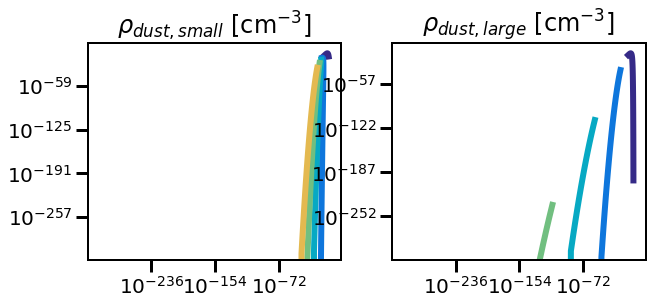

In [190]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,4), sharex=True)
ax = axes.reshape(-1)
fig.set_facecolor('w')

indices = [0, 1, 4, 3, 5, 6]
zrs = [0,0.1,0.2,0.3,0.4]

d_new = open_raw(data_paths[1])
d_old = open_raw(data_paths[-1])

for i in range(2):
    
    if indices[i] != 6:
        rrn, zzn, ddn = make_line_profiles(d_new, indices[i], zrs=zrs)
        rro, zzo, ddo = make_line_profiles(d_old, indices[i], zrs=zrs)
    else:
        pn = pressure_profile(d_new[4], d_new[5], mu=2.3).value
        rrn, zzn, ddn = make_line_profiles(d_new, indices[i], p=pn, zrs=zrs)
        
        po = pressure_profile(d_old[4], d_new[5], mu=2.3).value
        rro, zzo, ddo = make_line_profiles(d_old, indices[i], p=po, zrs=zrs)
    
    ax[i].set_title(output_labels[indices[i]])
    
    for j in range(len(rrn)):
        ax[i].plot(ddo[j], ddn[j], c=parula[j*50], lw=6)
        #ax[i].plot(rrn[j], ddo[j], c=parula[j*50], lw=6, linestyle='--')
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')

In [141]:
tab = Table()
xx = -1
d = open_raw(data_paths[xx])
for i in range(len(d)-1):
    if i < 6:
        rr, zz, dd = make_line_profiles(d, index=i, zrs=zrs)
    else:
        p = pressure_profile(d[4], d[5],mu=2.3).value
        _, _, dd = make_line_profiles(d, 6, p=p, zrs=zrs)
        
    if i == 0:
        tab.add_column(Column(rr[0], 'R'))
        tab.add_column(Column(zz[0], 'Z'))
    for j in range(len(np.array(dd))):
        tab.add_column(Column(dd[j], '{}_zr_{}'.format(output[i], zrs[j])))
        
tab.write('/Users/arcticfox/Documents/disks/{}.txt'.format(data_folders[xx]),
          format='ascii')